# Modeling and Analysis
*Deval Mehta*

With EDA complete, we move on to our main task: creating data-driven models to make better decisions about bus routes. In addition to the conventional machine learning models we have discussed throughout the course of DSB, we explore **graph-based analysis** here, treating the network of bus stops across eastern Queens as a graph, where the nodes are stops and the edges are connections between stops, based either on established routes or using a distance heuristic. Our goals for modeling are as follows:
- Instantiate and run DBSCAN to check for areas of high and low density, which will be transit hubs and underserved areas
- Model the stop network as a graph, then use PageRank to define transit hubs and underserved areas

DBSCAN and PageRank both proved unfruitful for different reasons. In the case of DBSCAN, finding an adequate value for epsilon proved difficult. PageRank is designed for directed graphs and New York's public transit network is better described as an undirected graph. For these reasons, we opt instead for HDBSCAN, which no longer requires specifying the parameter `eps` and the Louvain method, a greedy algorithm for determining the community structure of a graph.

## Imports and Reading in Data

In [66]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import networkx as nx
import community as clouvain

import glob
import hdbscan

from collections import Counter
from geopy.distance import geodesic
from itertools import combinations
from tqdm import tqdm

from scipy.spatial import cKDTree
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, root_mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SARIMAX

In [2]:
# File Paths
data_directory = "../data/"
static_data_file = f"{data_directory}stops.csv"
geojson_file = f"{data_directory}nyc_by_neighborhood_2020.geojson"
real_time_files_pattern = f"{data_directory}realtime_data_MTA NYCT_*.csv"

In [35]:
# Load Static Data
stops_data = pd.read_csv(static_data_file)
stops_data.rename(
    columns={
        "Route ID": "route_id",
        "Stop ID": "stop_id",
        "Stop Name": "stop_name",
        "Latitude": "stop_lat",
        "Longitude": "stop_lon",
    },
    inplace=True,
)

stops_data["route_id"] = stops_data["route_id"].str.replace('%20', ' ', regex=False)
stops_data["coords"] = stops_data[["stop_lat", "stop_lon"]].apply(tuple, axis=1)

# Convert to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

In [36]:
# Load Queens Map
nyc_map = gpd.read_file(geojson_file)
queens_map = nyc_map[nyc_map["boroname"].str.contains("Queens", case=False)]

In [37]:
# Function to visualize results
def visualize_clusters(df, cluster_col, title, map_data=None, map_color="lightgray", map_edgecolor="black"):
    """
    Visualize clusters with transparency and overlay a layer showing all stops.

    Parameters:
    - df: GeoDataFrame containing the clustering results.
    - cluster_col: Column name for cluster/community IDs.
    - title: Title for the plot.
    - map_data: GeoDataFrame for the base map (optional).
    - map_color: Color for the base map (default: light gray).
    - map_edgecolor: Edge color for the base map (default: black).
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the base map (e.g., Queens neighborhoods)
    if map_data is not None:
        map_data.plot(ax=ax, color=map_color, edgecolor=map_edgecolor, alpha=0.5)
    
    # Plot all stops with a neutral color as a separate layer
    df.plot(ax=ax, color="black", markersize=10, alpha=0.5, label="All Stops")
    
    # Overlay clusters with transparency
    df.plot(
        ax=ax,
        column=cluster_col,
        cmap="tab20b",
        markersize=20,
        alpha=0.7,  # Add transparency to clusters
        legend=True
    )
    
    # Add title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

In [38]:
# Load Real-Time Data
real_time_files = glob.glob(real_time_files_pattern)
real_time_data = pd.concat([pd.read_csv(file) for file in real_time_files], ignore_index=True)

# Rename columns for consistency
real_time_data.rename(
    columns={
        "Route ID": "route_id",
        "Vehicle ID": "vehicle_id",
        "Latitude": "vehicle_lat",
        "Longitude": "vehicle_lon",
        "Timestamp": "timestamp",
    },
    inplace=True,
)

real_time_data["route_id"] = real_time_data["route_id"].str.strip()

# Ensure timestamp is parsed
real_time_data["timestamp"] = pd.to_datetime(real_time_data["timestamp"])

# Sort by route, vehicle, and timestamp
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

In [39]:
# Extract coordinates from stops_data
stop_coords = np.radians(stops_data[["stop_lat", "stop_lon"]].values)

# Extract vehicle coordinates from real-time data
real_time_coords = np.radians(real_time_data[["vehicle_lat", "vehicle_lon"]].values)

# Build a KDTree for efficient nearest neighbor search
stop_tree = cKDTree(stop_coords)

# Query the nearest stop for each real-time data point
distances, indices = stop_tree.query(real_time_coords)

# Assign the nearest stop_id to each real-time record
real_time_data["nearest_stop_id"] = stops_data.iloc[indices]["stop_id"].values
real_time_data["distance_to_stop"] = distances * 6371  # Convert radians to kilometers

## DBSCAN

In [8]:
# Step 1: Run DBSCAN
eps = 0.00005  # Adjust based on your data
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine")
stops_data["cluster"] = dbscan.fit_predict(np.radians(stops_data[["stop_lat", "stop_lon"]]))

In [9]:
# Step 2: Save and Visualize Clusters
stops_data.to_csv(f"{data_directory}dbscan_clusters.csv", index=False)
print("DBSCAN Cluster Counts:")
print(stops_data["cluster"].value_counts())

DBSCAN Cluster Counts:
cluster
 0    1996
 2     141
-1      74
 4      42
 6      18
 5      17
 1       8
 3       4
Name: count, dtype: int64


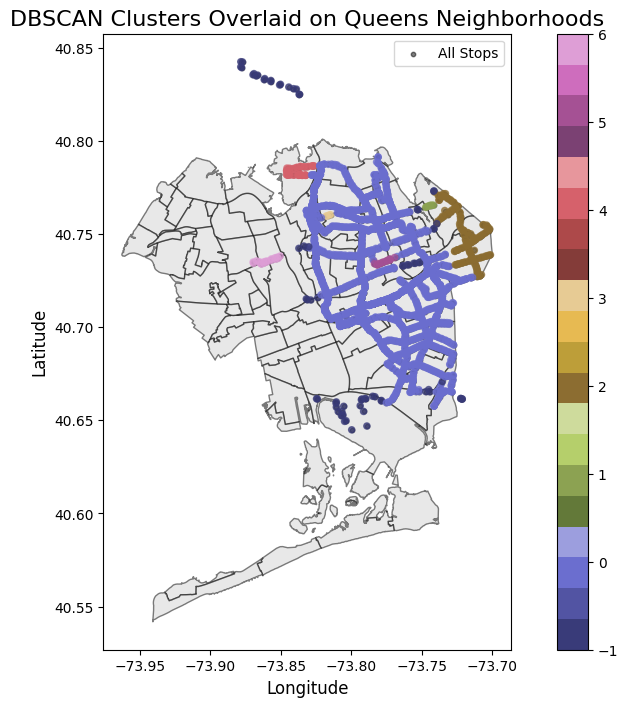

In [10]:
# Convert stops_data to GeoDataFrame if not already done
stops_gdf = gpd.GeoDataFrame(
    stops_data,
    geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326"
)

# Visualize DBSCAN Clusters with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="cluster", 
    title="DBSCAN Clusters Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

## PageRank
PageRank was developed by Google to rank webpages by importance, using the number of links leading to them as a proxy. It has since been generalized to apply to any directed graph. Modeling bus stops in this way should allow us to identify areas of high and low density, just as clustering would, but without machine learning.

In [46]:
# Step 1: Construct Edges Based on Proximity
distance_threshold = 0.1  # in kilometers (500 meters)
edges = []

print("Constructing edges for PageRank...")
for stop1, stop2 in tqdm(combinations(stops_data["stop_id"], 2), desc="Computing edges"):
    coord1 = stops_data.loc[stops_data["stop_id"] == stop1, "coords"].values[0]
    coord2 = stops_data.loc[stops_data["stop_id"] == stop2, "coords"].values[0]
    if geodesic(coord1, coord2).kilometers <= distance_threshold:
        edges.append((stop1, stop2))

Constructing edges for PageRank...


Computing edges: 2643850it [27:33, 1598.56it/s]


In [47]:
# Step 2: Create a Directed Graph
G = nx.DiGraph()

# Add nodes
for _, row in stops_data.iterrows():
    G.add_node(row["stop_id"], latitude=row["stop_lat"], longitude=row["stop_lon"])

# Add edges
G.add_edges_from(edges)

In [48]:
# Step 3: Compute PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)
stops_data["pagerank"] = stops_data["stop_id"].map(pagerank_scores)

# Step 4: Save and Visualize PageRank Results
stops_data.to_csv(f"{data_directory}pagerank_results.csv", index=False)
print("Top 10 Bus Stops by PageRank:")
print(stops_data.sort_values("pagerank", ascending=False).head(10))

Top 10 Bus Stops by PageRank:
             route_id     stop_id                 stop_name   stop_lat  \
574    MTA%20NYCT_Q13  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
1046   MTA%20NYCT_Q28  MTA_505121       39 AV/LIPPMAN PLAZA  40.760694   
802   MTA%20NYCT_Q20B  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
678   MTA%20NYCT_Q20A  MTA_505021  15 AV/COLLEGE POINT BLVD  40.784153   
67      MTA%20NYCT_Q1  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
135     MTA%20NYCT_Q2  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1351   MTA%20NYCT_Q36  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1717   MTA%20NYCT_Q76  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1833   MTA%20NYCT_Q77  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   
1447   MTA%20NYCT_Q43  MTA_501414  HILLSIDE AV/MIDLAND PKWY  40.712620   

       stop_lon                   coords  hdbscan_cluster  louvain_community  \
574  -73.828177  (40.760694, -73.828177)                0                1.

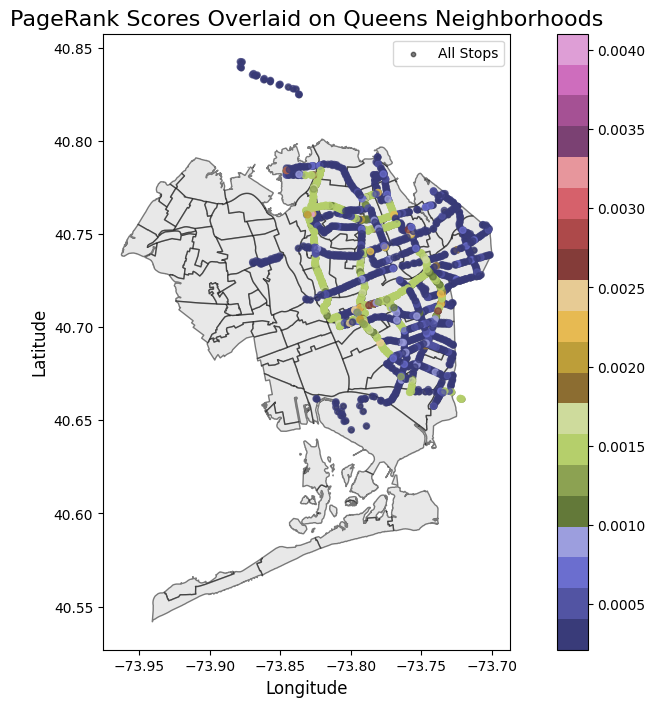

In [50]:
# Convert stops_data to GeoDataFrame if not already done
stops_gdf = gpd.GeoDataFrame(
    stops_data,
    geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]),
    crs="EPSG:4326"
)

# Visualize PageRank Scores with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="pagerank", 
    title="PageRank Scores Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

## HDBSCAN

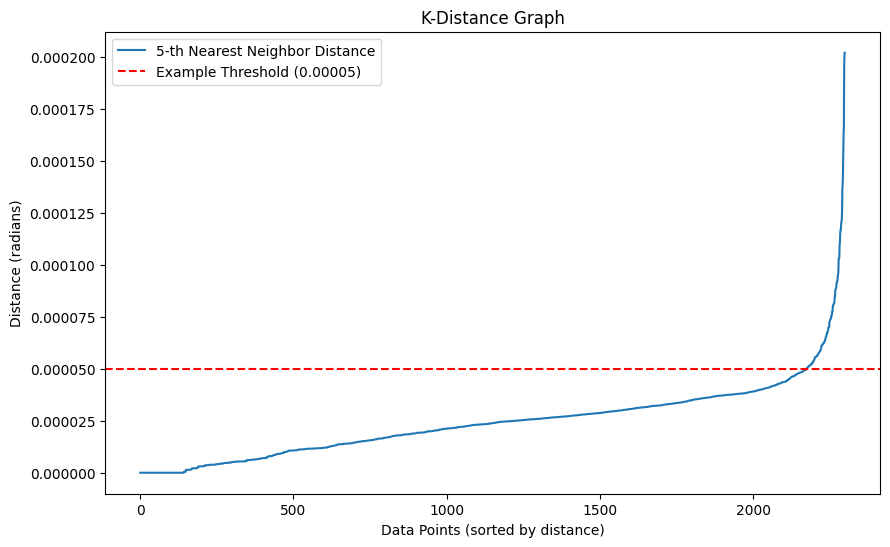

In [40]:
# Compute k-nearest neighbors
coords_radians = np.radians(stops_data[["stop_lat", "stop_lon"]].values)
k = 5  # Choose a small k for local density estimation
nbrs = NearestNeighbors(n_neighbors=k, metric="haversine").fit(coords_radians)
distances, indices = nbrs.kneighbors(coords_radians)

# Plot k-distance graph
distances = np.sort(distances[:, -1])  # k-th nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.plot(distances, label=f"{k}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel("Distance (radians)")
plt.axhline(y=0.00005, color="r", linestyle="--", label="Example Threshold (0.00005)")
plt.legend()
plt.show()

In [41]:
# Define grid search ranges
min_cluster_size_range = [50, 100, 150]  # Larger clusters
min_samples_range = [20, 30, 40]         # Tighten density requirements

# Grid search for HDBSCAN parameters
best_model = None
best_score = float("-inf")

print("Performing grid search over HDBSCAN parameters...")
for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="haversine"
        )
        labels = clusterer.fit_predict(coords_radians)
        
        # Compute Silhouette Score for validation
        if len(set(labels)) > 1:
            score = silhouette_score(coords_radians, labels, metric="haversine")
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}, Silhouette Score={score:.3f}")
            if score > best_score:
                best_score = score
                best_model = clusterer

# Assign best HDBSCAN results
stops_data["hdbscan_cluster"] = best_model.labels_

# Update stops_gdf to include the HDBSCAN cluster labels
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

Performing grid search over HDBSCAN parameters...
min_cluster_size=50, min_samples=20, Silhouette Score=0.117
min_cluster_size=50, min_samples=30, Silhouette Score=0.106
min_cluster_size=50, min_samples=40, Silhouette Score=-0.061
min_cluster_size=100, min_samples=20, Silhouette Score=0.004
min_cluster_size=100, min_samples=30, Silhouette Score=-0.070
min_cluster_size=100, min_samples=40, Silhouette Score=-0.079
min_cluster_size=150, min_samples=20, Silhouette Score=0.004
min_cluster_size=150, min_samples=30, Silhouette Score=0.181
min_cluster_size=150, min_samples=40, Silhouette Score=-0.037


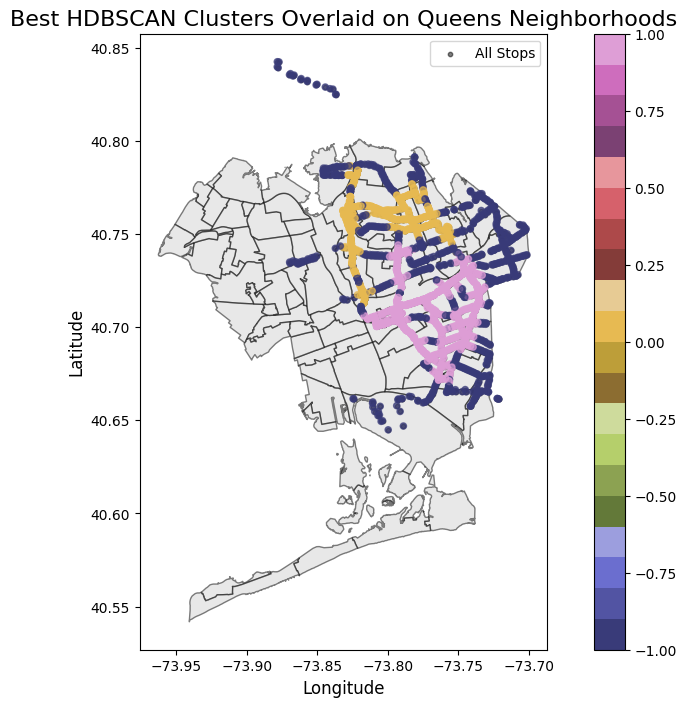

Best HDBSCAN clustering complete. Results saved.


In [42]:
# Visualize HDBSCAN clusters
visualize_clusters(
    stops_gdf,
    cluster_col="hdbscan_cluster",
    title="Best HDBSCAN Clusters Overlaid on Queens Neighborhoods",
    map_data=queens_map
)

# Save HDBSCAN results
stops_data.to_csv(f"{data_directory}hdbscan_best_clusters.csv", index=False)
print("Best HDBSCAN clustering complete. Results saved.")

## Louvain Method

In [43]:
# Add edges with weights from real-time data
edges = []
for route_id in real_time_data["route_id"].unique():
    route_data = real_time_data[real_time_data["route_id"] == route_id]
    for vehicle_id in route_data["vehicle_id"].unique():
        vehicle_data = route_data[route_data["vehicle_id"] == vehicle_id]
        stops = vehicle_data["nearest_stop_id"].tolist()
        for i in range(len(stops) - 1):
            stop1, stop2 = stops[i], stops[i + 1]
            if stop1 != stop2:  # Avoid self-loops
                coord1 = stops_data.loc[stops_data["stop_id"] == stop1, "coords"].values[0]
                coord2 = stops_data.loc[stops_data["stop_id"] == stop2, "coords"].values[0]
                distance = geodesic(coord1, coord2).kilometers
                edges.append((stop1, stop2, {"weight": 1 / distance}))  # Weight by inverse distance

# Create Graph with Real-Time Data Edges
G = nx.Graph()

# Add nodes
G.add_nodes_from(stops_data["stop_id"])

# Add edges from real-time data
G.add_edges_from(edges)

# Filter edges by weight (e.g., distance or frequency)
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] > threshold]
# Sort real-time data for each vehicle and route
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

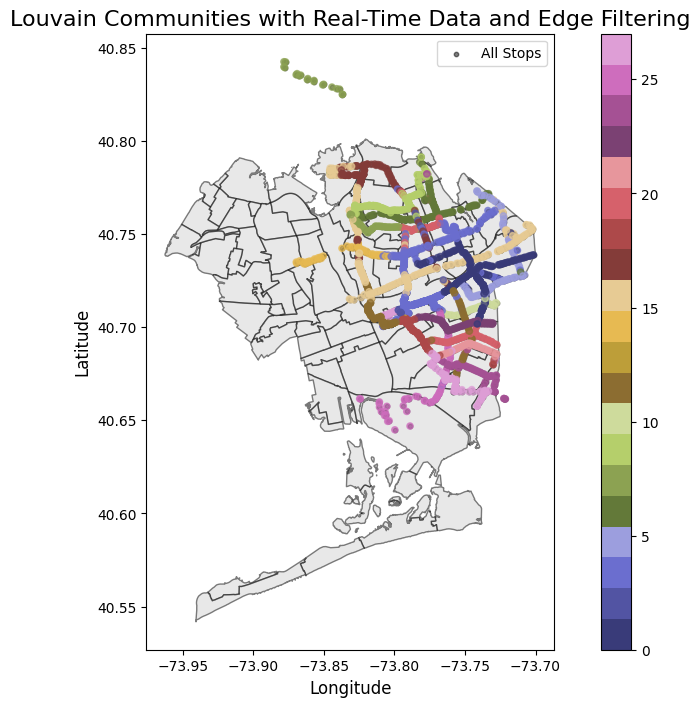

Louvain clustering with real-time data complete. Results saved.


In [44]:
# Filter edges by weight
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in edges if d["weight"] > threshold]

# Create graph with filtered edges
G = nx.Graph()
G.add_edges_from(filtered_edges)

# Run Louvain Method with higher resolution
partition = clouvain.best_partition(G, weight="weight", resolution=2.0)  # Higher resolution for finer clusters
stops_data["louvain_community"] = stops_data["stop_id"].map(partition)

# Update stops_gdf to include the HDBSCAN cluster labels
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

# Visualize Louvain communities
visualize_clusters(
    stops_gdf,
    cluster_col="louvain_community",
    title="Louvain Communities with Real-Time Data and Edge Filtering",
    map_data=queens_map
)

# Save Louvain results
stops_data.to_csv(f"{data_directory}louvain_with_realtime.csv", index=False)
print("Louvain clustering with real-time data complete. Results saved.")

In [45]:
# Save Louvain results
stops_data.to_csv(f"{data_directory}louvain_communities_realtime.csv", index=False)
print("Louvain community detection with real-time edges complete. Results saved.")

Louvain community detection with real-time edges complete. Results saved.


In [46]:
# Modularity
modularity_score = clouvain.modularity(partition, G, weight="weight")
print(f"Modularity Score: {modularity_score:.4f}")

# Community Size Distribution
community_sizes = Counter(partition.values())
print("Community Size Distribution:", community_sizes)

Modularity Score: 0.7565
Community Size Distribution: Counter({4: 143, 16: 139, 6: 113, 9: 102, 1: 81, 5: 78, 17: 78, 0: 76, 26: 74, 25: 65, 24: 64, 22: 63, 15: 58, 3: 57, 20: 51, 8: 48, 14: 48, 18: 47, 12: 46, 21: 46, 10: 39, 19: 37, 11: 33, 2: 19, 7: 19, 27: 11, 23: 3, 13: 2})


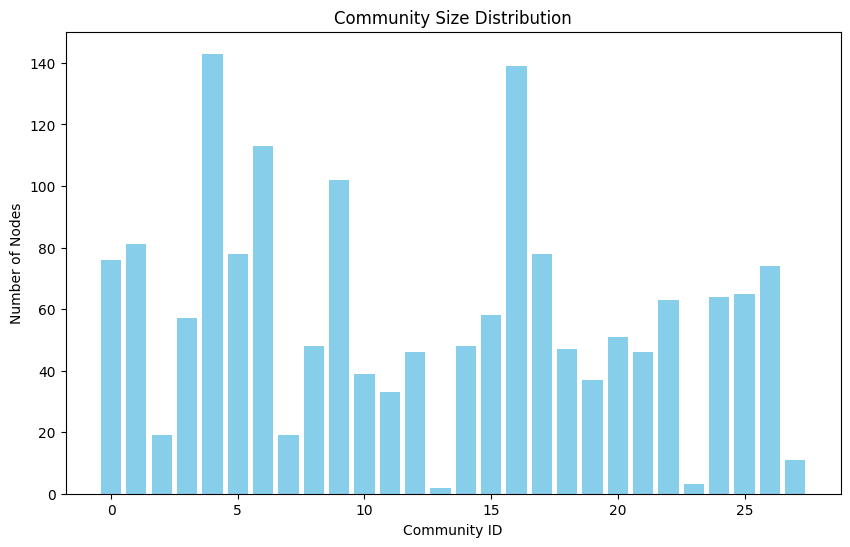

In [47]:
# Plot Community Size Distribution
plt.figure(figsize=(10, 6))
plt.bar(community_sizes.keys(), community_sizes.values(), color="skyblue")
plt.title("Community Size Distribution")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

In [48]:
# Coverage
def compute_coverage(G, partition):
    intra_edges = sum(1 for edge in G.edges if partition[edge[0]] == partition[edge[1]])
    total_edges = G.number_of_edges()
    return intra_edges / total_edges

coverage = compute_coverage(G, partition)
print(f"Coverage: {coverage:.4f}")

Coverage: 0.3924


In [49]:
import folium

# Create a map
map_center = [stops_gdf["stop_lat"].mean(), stops_gdf["stop_lon"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add stops
for _, row in stops_gdf.iterrows():
    folium.CircleMarker(
        location=(row["stop_lat"], row["stop_lon"]),
        radius=3,
        color="black",
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

# Save or display the map
m.save("louvain_clusters_map.html")

## Time Series Analysis

In [56]:
# 1. Data Preparation
route_ids = stops_data["route_id"].unique()
all_data = []
for route_id in tqdm(route_ids, desc="Processing Routes"):
    df = real_time_data[real_time_data["route_id"] == route_id]
    df["Route"] = route_id
    all_data.append(df)

# Combine all routes
combined_data = pd.concat(all_data)
combined_data.set_index("timestamp", inplace=True)

# Resample data to hourly frequency
hourly_data = combined_data.resample("H").count()
hourly_data.reset_index(inplace=True)


Processing Routes:   0%|                                                                        | 0/23 [00:00<?, ?it/s]C:\Users\deval\AppData\Local\Temp\ipykernel_2832\3438369547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Route"] = route_id
C:\Users\deval\AppData\Local\Temp\ipykernel_2832\3438369547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Route"] = route_id
C:\Users\deval\AppData\Local\Temp\ipykernel_2832\3438369547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a

Plotting Trends:   0%|                                                                          | 0/23 [00:00<?, ?it/s]C:\Users\deval\AppData\Local\Temp\ipykernel_2832\553858705.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_activity = route_data.resample("H").size()
C:\Users\deval\AppData\Local\Temp\ipykernel_2832\553858705.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_activity = route_data.resample("H").size()
C:\Users\deval\AppData\Local\Temp\ipykernel_2832\553858705.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_activity = route_data.resample("H").size()
C:\Users\deval\AppData\Local\Temp\ipykernel_2832\553858705.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_activity = route_data.resample("H").size()
C:\Users\deval\AppDat

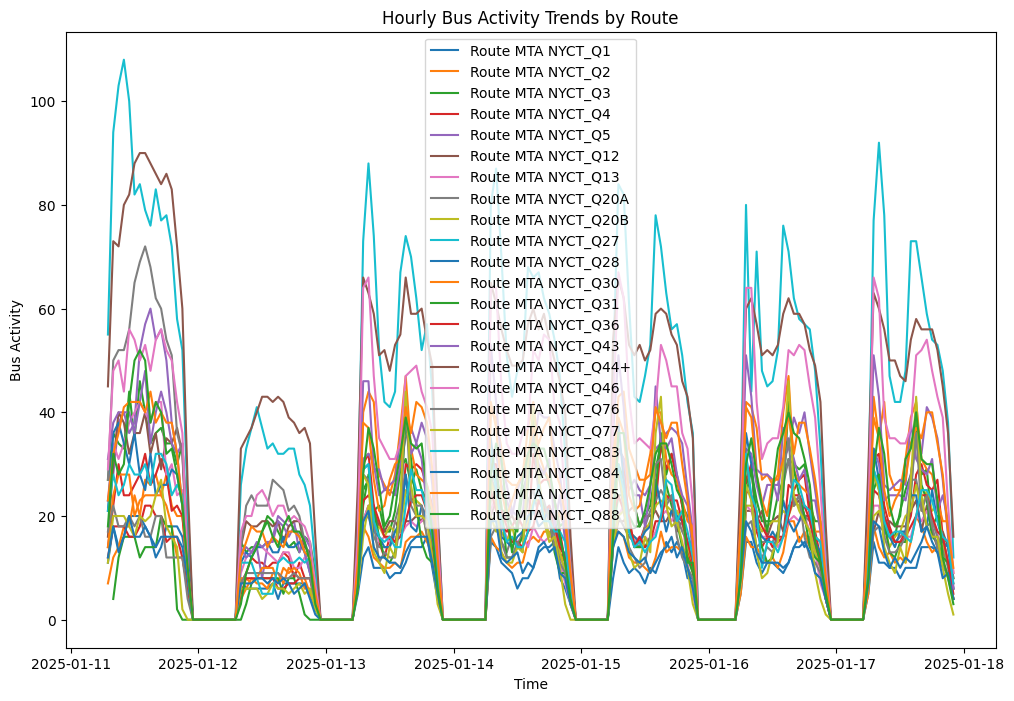

In [57]:
# 2. Exploratory Analysis
plt.figure(figsize=(12, 8))
for route_id in tqdm(combined_data["Route"].unique(), desc="Plotting Trends"):
    route_data = combined_data[combined_data["Route"] == route_id]
    hourly_activity = route_data.resample("H").size()
    plt.plot(hourly_activity.index, hourly_activity.values, label=f"Route {route_id}")

plt.xlabel("Time")
plt.ylabel("Bus Activity")
plt.title("Hourly Bus Activity Trends by Route")
plt.legend()
plt.show()

C:\Users\deval\AppData\Local\Temp\ipykernel_2832\3256407905.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()
Fitting STL Decomposition:   0%|                                                                 | 0/1 [00:00<?, ?it/s]


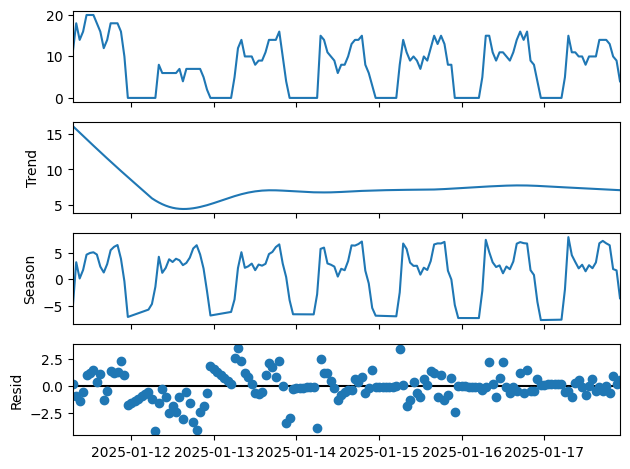

In [58]:
# 3. Seasonality and Trend Analysis
route_id = route_ids[0]  # Analyze the first route for demonstration
route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()
stl = STL(route_data, period=24)
with tqdm(desc="Fitting STL Decomposition", total=1):
    result = stl.fit()
result.plot()
plt.show()

In [59]:
# Metrics for Seasonality and Trend Analysis
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Pearson correlation between trend and observed data
correlation_trend, _ = pearsonr(trend[~np.isnan(trend)], route_data[~np.isnan(trend)])
print(f"Correlation between trend and observed data: {correlation_trend:.2f}")

Correlation between trend and observed data: 0.46


In [84]:
# 4. Clustering Temporal Patterns
activity_matrix = combined_data.pivot_table(
    index=combined_data.index.hour,  # Hour of day
    columns="Route",
    values="vehicle_id",
    aggfunc="count",
    fill_value=0
)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(activity_matrix.T)

with tqdm(desc="Clustering Temporal Patterns", total=1):
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(normalized_data)

# Silhouette Score for Clustering
silhouette_avg = silhouette_score(normalized_data, labels)
print(f"Silhouette Score for Temporal Clustering: {silhouette_avg:.2f}")

Clustering Temporal Patterns:   0%|                                                              | 0/1 [00:00<?, ?it/s]

Silhouette Score for Temporal Clustering: 0.47


In [85]:
# 5. Forecasting with SARIMA
route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()

# Define SARIMA model with daily seasonality
model = SARIMAX(route_data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 24))
with tqdm(desc="Fitting SARIMA Model", total=1):
    fitted_model = model.fit()

forecast = fitted_model.forecast(steps=24)

C:\Users\deval\AppData\Local\Temp\ipykernel_2832\3155288374.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()
Fitting SARIMA Model:   0%|                                                                      | 0/1 [00:00<?, ?it/s]C:\Users\deval\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\deval\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\deval\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\b

In [86]:
# Calculate Mean Squared Error (MSE) for validation
observed = route_data[-24:]  # Last 24 hours for comparison
rmse = root_mean_squared_error(observed, forecast[:len(observed)])
print(f"Mean Squared Error of Forecast: {rmse:.2f}")

Mean Squared Error of Forecast: 1.67


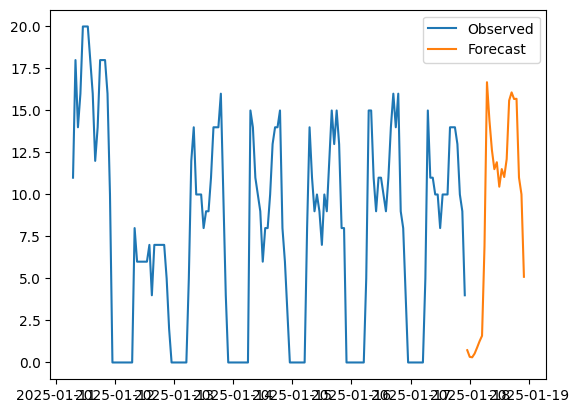

In [87]:
plt.plot(route_data, label="Observed")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()

In [88]:
# 6. Temporal Coverage Analysis
real_time_data["Time Gap"] = real_time_data["timestamp"].diff().dt.total_seconds() / 60
with tqdm(desc="Identifying Large Gaps", total=1):
    large_gaps = real_time_data[real_time_data["Time Gap"] > 30]
print(large_gaps)

# Metrics for Coverage Analysis
coverage_percentage = 100 * (1 - large_gaps.shape[0] / real_time_data.shape[0])
print(f"Coverage Percentage: {coverage_percentage:.2f}%")

Identifying Large Gaps:   0%|                                                                    | 0/1 [00:00<?, ?it/s]

           route_id     vehicle_id  vehicle_lat  vehicle_lon  \
1154    MTA NYCT_Q1  MTA NYCT_8000    40.728656   -73.743449   
1163    MTA NYCT_Q1  MTA NYCT_8000    40.707910   -73.795797   
1164    MTA NYCT_Q1  MTA NYCT_8000    40.725585   -73.740205   
1175    MTA NYCT_Q1  MTA NYCT_8000    40.722191   -73.757774   
1182    MTA NYCT_Q1  MTA NYCT_8000    40.707925   -73.795758   
...             ...            ...          ...          ...   
59254  MTA NYCT_Q88  MTA NYCT_8846    40.740898   -73.758047   
59266  MTA NYCT_Q88  MTA NYCT_8846    40.717932   -73.736359   
59285  MTA NYCT_Q88  MTA NYCT_8846    40.738493   -73.799801   
59297  MTA NYCT_Q88  MTA NYCT_8846    40.733955   -73.864459   
59311  MTA NYCT_Q88  MTA NYCT_8846    40.729666   -73.744539   

                       timestamp nearest_stop_id  distance_to_stop   Time Gap  
1154  2025-01-17 16:44:21.733455      MTA_500027          0.080143  30.096650  
1163  2025-01-17 17:14:27.681662      MTA_504421          0.002813  30.

In [95]:
print("Activity Counts:")
print(activity_counts)

print("\nStop Counts:")
print(stop_counts)

Activity Counts:
               vehicle_id
Route                    
MTA NYCT_Q1          1221
MTA NYCT_Q12         2233
MTA NYCT_Q13         1992
MTA NYCT_Q2          1473
MTA NYCT_Q20A        2527
MTA NYCT_Q20B        1428
MTA NYCT_Q27         6180
MTA NYCT_Q28         2163
MTA NYCT_Q3          2638
MTA NYCT_Q30         2821
MTA NYCT_Q31         1767
MTA NYCT_Q36         1839
MTA NYCT_Q4          2238
MTA NYCT_Q43         3101
MTA NYCT_Q44+        5977
MTA NYCT_Q46         4371
MTA NYCT_Q5          3164
MTA NYCT_Q76         1829
MTA NYCT_Q77         1781
MTA NYCT_Q83         2097
MTA NYCT_Q84         1349
MTA NYCT_Q85         3188
MTA NYCT_Q88         2798

Stop Counts:
route_id
MTA NYCT_Q1       83
MTA NYCT_Q12      69
MTA NYCT_Q13      93
MTA NYCT_Q2       67
MTA NYCT_Q20A    119
MTA NYCT_Q20B    125
MTA NYCT_Q27     153
MTA NYCT_Q28      73
MTA NYCT_Q3      108
MTA NYCT_Q30     110
MTA NYCT_Q31     121
MTA NYCT_Q36     134
MTA NYCT_Q4       70
MTA NYCT_Q43      95
MTA NYCT_Q44+   

In [96]:
aligned_activity_counts = activity_counts.reindex(stop_counts.index, fill_value=0)
print("\nAligned Activity Counts:")
print(aligned_activity_counts)


Aligned Activity Counts:
               vehicle_id
route_id                 
MTA NYCT_Q1          1221
MTA NYCT_Q12         2233
MTA NYCT_Q13         1992
MTA NYCT_Q2          1473
MTA NYCT_Q20A        2527
MTA NYCT_Q20B        1428
MTA NYCT_Q27         6180
MTA NYCT_Q28         2163
MTA NYCT_Q3          2638
MTA NYCT_Q30         2821
MTA NYCT_Q31         1767
MTA NYCT_Q36         1839
MTA NYCT_Q4          2238
MTA NYCT_Q43         3101
MTA NYCT_Q44+        5977
MTA NYCT_Q46         4371
MTA NYCT_Q5          3164
MTA NYCT_Q76         1829
MTA NYCT_Q77         1781
MTA NYCT_Q83         2097
MTA NYCT_Q84         1349
MTA NYCT_Q85         3188
MTA NYCT_Q88         2798


In [97]:
for route_id in stop_counts.index:
    print(f"Route: {route_id}")
    print(f"Activity Count: {aligned_activity_counts.loc[route_id, 'vehicle_id']}")
    print(f"Stop Count: {stop_counts[route_id]}")
    print(f"Ratio: {aligned_activity_counts.loc[route_id, 'vehicle_id'] / stop_counts[route_id]}")

Route: MTA NYCT_Q1
Activity Count: 1221
Stop Count: 83
Ratio: 14.710843373493976
Route: MTA NYCT_Q12
Activity Count: 2233
Stop Count: 69
Ratio: 32.36231884057971
Route: MTA NYCT_Q13
Activity Count: 1992
Stop Count: 93
Ratio: 21.419354838709676
Route: MTA NYCT_Q2
Activity Count: 1473
Stop Count: 67
Ratio: 21.98507462686567
Route: MTA NYCT_Q20A
Activity Count: 2527
Stop Count: 119
Ratio: 21.235294117647058
Route: MTA NYCT_Q20B
Activity Count: 1428
Stop Count: 125
Ratio: 11.424
Route: MTA NYCT_Q27
Activity Count: 6180
Stop Count: 153
Ratio: 40.3921568627451
Route: MTA NYCT_Q28
Activity Count: 2163
Stop Count: 73
Ratio: 29.63013698630137
Route: MTA NYCT_Q3
Activity Count: 2638
Stop Count: 108
Ratio: 24.425925925925927
Route: MTA NYCT_Q30
Activity Count: 2821
Stop Count: 110
Ratio: 25.645454545454545
Route: MTA NYCT_Q31
Activity Count: 1767
Stop Count: 121
Ratio: 14.603305785123966
Route: MTA NYCT_Q36
Activity Count: 1839
Stop Count: 134
Ratio: 13.723880597014926
Route: MTA NYCT_Q4
Activity

In [100]:
# 7. Comparative Analysis
with tqdm(desc="Comparing Activity-to-Stop Ratios", total=1):
    # Group combined_data by route and count vehicle activity
    activity_counts = combined_data.groupby("Route")[["vehicle_id"]].count()

    # Group stops_data by route and count the number of stops
    stop_counts = stops_data.groupby("route_id").size()

    # Align indices to a common index
    common_index = activity_counts.index.intersection(stop_counts.index)
    aligned_activity_counts = activity_counts.loc[common_index].astype(float)
    stop_counts = stop_counts.loc[common_index].astype(float)

    # Compute the ratio
    combined_summary = (aligned_activity_counts / stop_counts).fillna(0)

# Debug Outputs
print("\nAligned Activity Counts:")
print(aligned_activity_counts)

print("\nStop Counts:")
print(stop_counts)

print("\nCombined Summary After Division:")
print(combined_summary)

Comparing Activity-to-Stop Ratios:   0%|                                                         | 0/1 [00:00<?, ?it/s]


Aligned Activity Counts:
               vehicle_id
MTA NYCT_Q1        1221.0
MTA NYCT_Q12       2233.0
MTA NYCT_Q13       1992.0
MTA NYCT_Q2        1473.0
MTA NYCT_Q20A      2527.0
MTA NYCT_Q20B      1428.0
MTA NYCT_Q27       6180.0
MTA NYCT_Q28       2163.0
MTA NYCT_Q3        2638.0
MTA NYCT_Q30       2821.0
MTA NYCT_Q31       1767.0
MTA NYCT_Q36       1839.0
MTA NYCT_Q4        2238.0
MTA NYCT_Q43       3101.0
MTA NYCT_Q44+      5977.0
MTA NYCT_Q46       4371.0
MTA NYCT_Q5        3164.0
MTA NYCT_Q76       1829.0
MTA NYCT_Q77       1781.0
MTA NYCT_Q83       2097.0
MTA NYCT_Q84       1349.0
MTA NYCT_Q85       3188.0
MTA NYCT_Q88       2798.0

Stop Counts:
MTA NYCT_Q1       83.0
MTA NYCT_Q12      69.0
MTA NYCT_Q13      93.0
MTA NYCT_Q2       67.0
MTA NYCT_Q20A    119.0
MTA NYCT_Q20B    125.0
MTA NYCT_Q27     153.0
MTA NYCT_Q28      73.0
MTA NYCT_Q3      108.0
MTA NYCT_Q30     110.0
MTA NYCT_Q31     121.0
MTA NYCT_Q36     134.0
MTA NYCT_Q4       70.0
MTA NYCT_Q43      95.0
MTA NYCT_Q44+ 

In [90]:
# Merge route_labels with stops_data
louvain_temporal_data = stops_data.merge(
    route_labels,
    left_on="route_id",
    right_index=True,
    how="left"
)

# Analyze patterns by Louvain community
community_analysis = louvain_temporal_data.groupby("louvain_community")["Cluster"].value_counts(normalize=True)

print("Community-level temporal clustering proportions:")
print(community_analysis)

Community-level temporal clustering proportions:
louvain_community  Cluster
0.0                0          0.516393
                   2          0.459016
                   1          0.024590
1.0                2          0.388489
                   1          0.359712
                                ...   
25.0               2          1.000000
26.0               2          0.806452
                   0          0.193548
27.0               2          0.727273
                   0          0.272727
Name: proportion, Length: 64, dtype: float64


In [91]:
# Visualize temporal patterns for specific Louvain clusters
for community_id in louvain_temporal_data["louvain_community"].unique():
    community_data = louvain_temporal_data[louvain_temporal_data["louvain_community"] == community_id]
    print(f"Louvain Community {community_id} Temporal Cluster Distribution:")
    print(community_data["Cluster"].value_counts())

Louvain Community 2.0 Temporal Cluster Distribution:
Cluster
0    23
2     5
Name: count, dtype: int64
Louvain Community 3.0 Temporal Cluster Distribution:
Cluster
0    115
2     41
Name: count, dtype: int64
Louvain Community 0.0 Temporal Cluster Distribution:
Cluster
0    63
2    56
1     3
Name: count, dtype: int64
Louvain Community 1.0 Temporal Cluster Distribution:
Cluster
2    54
1    50
0    35
Name: count, dtype: int64
Louvain Community 5.0 Temporal Cluster Distribution:
Cluster
0    77
2     2
Name: count, dtype: int64
Louvain Community 4.0 Temporal Cluster Distribution:
Cluster
2    122
0     49
1     23
Name: count, dtype: int64
Louvain Community nan Temporal Cluster Distribution:
Series([], Name: count, dtype: int64)
Louvain Community 10.0 Temporal Cluster Distribution:
Cluster
0    40
1     2
Name: count, dtype: int64
Louvain Community 25.0 Temporal Cluster Distribution:
Cluster
2    65
Name: count, dtype: int64
Louvain Community 26.0 Temporal Cluster Distribution:
Cluster
